In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

## Многомерное шкалирование(MDS)

Построение матрицы расстояний

In [3]:
dist_mat=np.array([[np.sqrt(np.sum((y-x)**2)) for y in X] for x in X])

Построение матриц A и B(см. материалы в pdf)

In [4]:
A=-0.5*dist_mat**2
mean_row=np.apply_along_axis(np.mean, 1, A)[:, np.newaxis]
mean_col=mean_row.flatten()[np.newaxis, :]
mean=np.mean(A)
B=A-mean_col-mean_row+mean

Находим собственные векторы и собственные значения

In [6]:
eig_values_mds, eig_vectors_mds = np.linalg.eig(B)

In [9]:
eig_values_mds[:2]

array([630.0080142 +0.j,  36.15794144+0.j])

In [13]:
np.sqrt(np.sum(eig_vectors_mds[:, 0]*np.conj(eig_vectors_mds[:, 0])))

(1+0j)

Numpy нормирует собственные векторы на единицу. Нам нужно отнормировать на собственные значения

In [14]:
Z_mds=np.real(eig_vectors_mds[:, :2])*np.sqrt(np.real(eig_values_mds[:2][np.newaxis, :]))

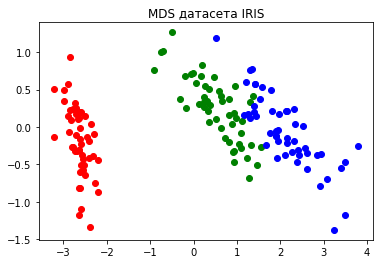

In [15]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z_mds[y==i, 0], Z_mds[y==i, 1], c=c)
plt.title('MDS датасета IRIS')
plt.show()

In [16]:
dist_mat_mds=np.array([[np.sqrt(np.sum((y-x)**2)) for y in Z_mds] for x in Z_mds]) # Матрица расстояний между построенными точками

Рассчёт показателя потерь

In [17]:
stress=np.sqrt(np.sum((dist_mat-dist_mat_mds)**2)/np.sum(dist_mat**2))
print(stress)

0.04179644853519393


## Метод главных компонент(PCA)

In [18]:
X_ = X.astype(float)
mean=np.apply_along_axis(np.mean, 0, X)
std=np.apply_along_axis(np.std, 0, X)
X_normed=(X-mean[np.newaxis, :])/std[np.newaxis, :]

In [19]:
covariance_matrix = X_normed.T.dot(X_normed)

In [20]:
covariance_matrix

array([[150.        , -17.63546762, 130.76306638, 122.69116894],
       [-17.63546762, 150.        , -64.26601565, -54.91888988],
       [130.76306638, -64.26601565, 150.        , 144.42981471],
       [122.69116894, -54.91888988, 144.42981471, 150.        ]])

In [21]:
# Найдем собственные векторы и собственные значения

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
437.77467247979916
137.10457072021063
22.013531335697262
3.107225464292915


In [22]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [23]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_normed.dot(W)

In [24]:
Z.T.dot(Z)

array([[4.37774672e+02, 1.30728761e-14],
       [1.30728761e-14, 1.37104571e+02]])

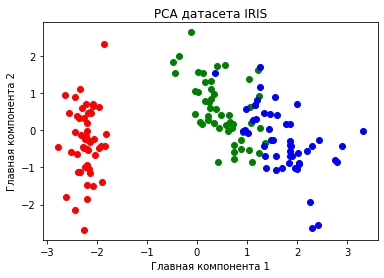

In [25]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

## Пример применение PCA для KNN

In [26]:
def e_metrics(x1, x2):
    return np.sqrt(np.sum((x2-x1)**2))


def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [27]:
from sklearn import model_selection
from sklearn.datasets import load_iris

In [28]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

In [29]:
# Для начала отмасштабируем выборку
X = X_train.astype(float)
mean=np.apply_along_axis(np.mean, 0, X)
std=np.apply_along_axis(np.std, 0, X)
X_normed_trained=(X-mean[np.newaxis, :])/std[np.newaxis, :]

In [30]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_normed_trained.T.dot(X_normed_trained)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52828393 -0.33212851]
 [-0.25412962 -0.93919659]
 [ 0.58193019 -0.02900891]
 [ 0.56364126 -0.0822125 ]]


In [31]:
new_X_train=X_normed_trained.dot(W)

In [32]:
X_normed_test=(X_test-mean[np.newaxis, :])/std[np.newaxis, :]
new_X_test=X_normed_test.dot(W)

In [33]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [34]:
k = 3

y_pred = knn(new_X_train, y_train, new_X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.933
